# **W1D2: Ocean-Atmosphere Reanalysis**

# **Tutorial 6: Ocean heat content**

**Week 1, Day 2: State of the Climate - Ocean and Atmospheric Reanalysis**

__Content creators:__ Aurora Basinski

**Content reviewers:** Katrina Dobson, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Ohad Zivan

**Content editors:** Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**
In this tutorial, our primary focus is the ocean's significant role in the climate system, particularly regarding its vast heat capacity. The ocean, having a heat capacity about 1000 times higher than the atmosphere due to its mass and specific heat capacity, is integral to the Earth's thermal equilibrium. It helps in the meridional heat transport from the equator to the poles, facilitated by both atmospheric and oceanic circulation.

The ocean's heat uptake plays a crucial role in mitigating the effects of anthropogenic climate change, as it absorbs about 90% of the excess heat and 25% of human-emitted CO2. This absorption largely occurs in the upper ocean, the region most in contact with the atmosphere.

Through this tutorial, we will dive into understanding the spatial structure of heat in the ocean and how this heat content is changing over time. To do this, we'll employ the [Estimating the Circulation and Climate of the Ocean (ECCO)](https://www.ecco-group.org/) dataset. By the end of this tutorial, you will have a deeper understanding of the dynamics of ocean's heat content and its pivotal role in the Earth's climate system.

In [1]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

# Setup
Here we import needed packages, and import ECCO data that has been preprocessed.
* Note: Here working with interpolated data fields to lat-lon grid

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean
import os
import pooch


In [4]:
#Import preprocessed ECCO data. This data is full depth temperature data over 1992 to 2016 (annual mean)
# this file takes about 5 minutes to load
url_theta = "https://osf.io/c8wqt/download"
theta_annual= xr.open_dataset(pooch.retrieve(url_theta, known_hash=None))
theta_annual=theta_annual.THETA
theta_annual=theta_annual.where(theta_annual != 0) #make land points equal to NaN
theta_annual

<xarray.DataArray 'THETA' (year: 25, Z: 50, latitude: 360, longitude: 720)>
array([[[[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [271.24949362, 271.24949362, 271.24949362, ..., 271.24949362,
          271.24949362, 271.24949362],
         [271.2454257 , 271.2454257 , 271.2454257 , ..., 271.2454257 ,
          271.2454257 , 271.2454257 ],
         [271.24057818, 271.24057818, 271.24057818, ..., 271.24057818,
          271.24057818, 271.24057818]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
...
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]],

        [[         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         ...,
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan],
         [         nan,          nan,          nan, ...,          nan,
                   nan,          nan]]]])
Coordinates:
    i          (longitude) int64 0 1 2 3 4 5 6 7 ... 713 714 715 716 717 718 719
    k          (Z) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    j          (latitude) int64 0 1 2 3 4 5 6 7 ... 353 354 355 356 357 358 359
  * latitude   (latitude) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * longitude  (longitude) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * Z          (Z) float32 -5.0 -15.0 -25.0 ... -5.039e+03 -5.461e+03 -5.906e+03
    dZ         (Z) float64 10.0 10.0 10.0 10.0 10.0 ... 387.5 410.5 433.5 456.5
    Zu         (Z) float64 -10.0 -20.0 -30.0 ... -5.678e+03 -6.134e+03
    dA         (latitude, longitude) float64 1.349e+07 1.349e+07 ... 1.349e+07
    dX         (latitude, longitude) float64 121.3 121.3 121.3 ... 121.3 121.3
  * year       (year) int64 1992 1993 1994 1995 1996 ... 2013 2014 2015 2016

# Section 1: Where is Ocean Heat Located Vertically?

In [5]:
#First let's take the mean over the period 1992 to 1994
subset_theta=theta_annual.sel(year=slice('1992', '1994')).mean('year')

Text(0.5, 1.0, 'Global zonal mean of temperature (C)')

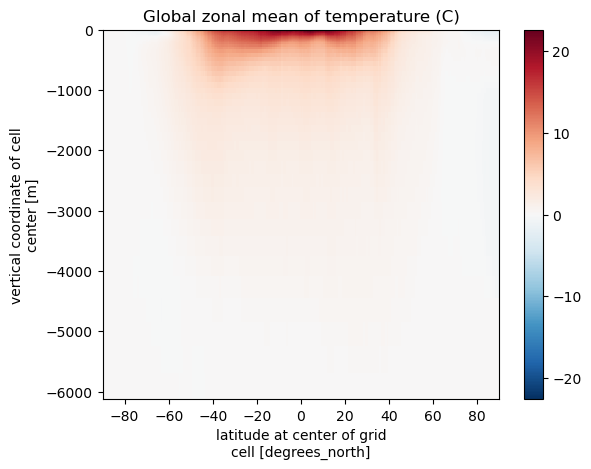

In [6]:
#Let's plot a zonal mean slice of this data. We take a mean just in longitudes by dividing the dA coordinate by the
(((subset_theta-273.15)*subset_theta.dX).sum('longitude')/(subset_theta.dX.sum('longitude'))).plot()
plt.title('Global zonal mean of temperature (C)')

We can observe that temperatures are warmer near the ocean's surface and closer to the Equator. Now, let's explore **what this implies for heat content and investigate where heat is stored in the ocean**. 

Heat is typically measured in Joules, which is equivalent to the units kg$*$m$^2$/s$^2$. To determine the heat content within a specific depth range, i.e., between a certain depth $z_1$ up to the surface (height of 0), we can calculate a *volume integral* over the dimensions $x,y,z$. The integral can be represented as follows:
$$\iiint_{z_1}^0 c_p*\rho_0*\theta(x,y,z) dz dA$$

Here, $dA$ represents the area integral (a double integral) over the $x$ and $y$ (lat, lon) coordinates. $\rho_0$ denotes the reference density in units of kg/m$^3$ and $c_p$ is specific heat capacity in units of J/(kg$*$K)

In [7]:
theta_area_int=(subset_theta*subset_theta.dA).sum('latitude').sum('longitude') #we take an area integral first at each depth level

Text(0.5, 1.0, 'Where heat is stored by depth')

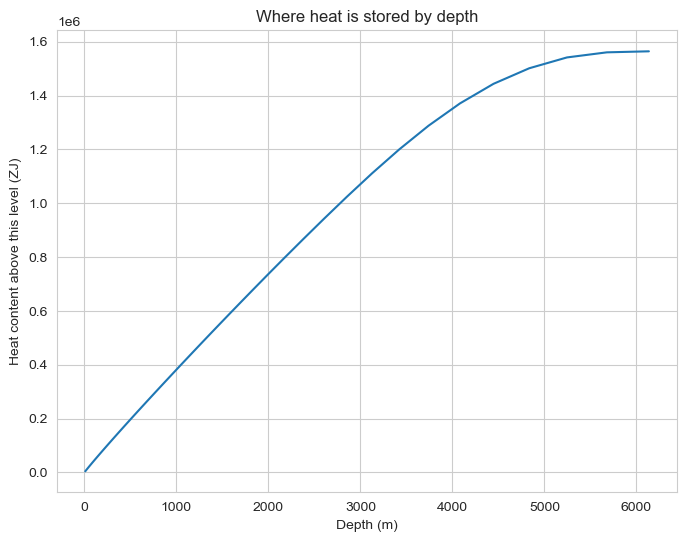

In [8]:
rho = 1026 #kg/m^3
c_p = 3990 #J/(kg K)

sns.set_style(style="whitegrid") #comment out if don't want seaborn background
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(-theta_annual.Zu,(rho*c_p*theta_area_int*subset_theta.dZ).cumsum()/10**21)
plt.xlabel('Depth (m)')
plt.ylabel('Heat content above this level (ZJ)')
plt.title('Where heat is stored by depth')

We observe that a greater amount of heat is concentrated in the upper ocean compared to the lower ocean. This aligns with our findings from the zonal mean plot, which indicated that the upper ocean tends to be warmer. Assuming that the total depth of the ocean is approximately 6000 meters, we can estimate the percentage of heat held in the top third of the ocean (top 2000 meters) by reading the values from the graph.

# Section 2: How is heat changing in time?

Let's examine the changes in ocean heat content over time throughout the entire depth of the ocean. Additionally, we will focus on two specific upper-ocean layers: one above 677 m and another above 1994 m. By analyzing these layers, we can identify where the changes in heat content occur within the water column.

In [9]:
#this cell may take a while to run!
rho = 1026 #kg/m^3
c_p = 3990 #J/(kg K)
global_heat=rho*c_p*((theta_annual*theta_annual.dZ*theta_annual.dA).sum('Z').sum('latitude').sum('longitude'))
global_heat_upper2000=rho*c_p*((theta_annual.where(theta_annual.Zu>-2000)*theta_annual.dZ*theta_annual.dA).sum('Z').sum('latitude').sum('longitude'))
global_heat_upper700=rho*c_p*((theta_annual.where(theta_annual.Zu>-700)*theta_annual.dZ*theta_annual.dA).sum('Z').sum('latitude').sum('longitude'))

heat_anom_fulldepth=global_heat-global_heat[0:5].mean() #remove first 5 year mean
heat_anom_upper2000=global_heat_upper2000-global_heat_upper2000[0:5].mean()
heat_anom_upper700=global_heat_upper700-global_heat_upper700[0:5].mean()

Text(0.5, 1.0, 'Change in heat over time')

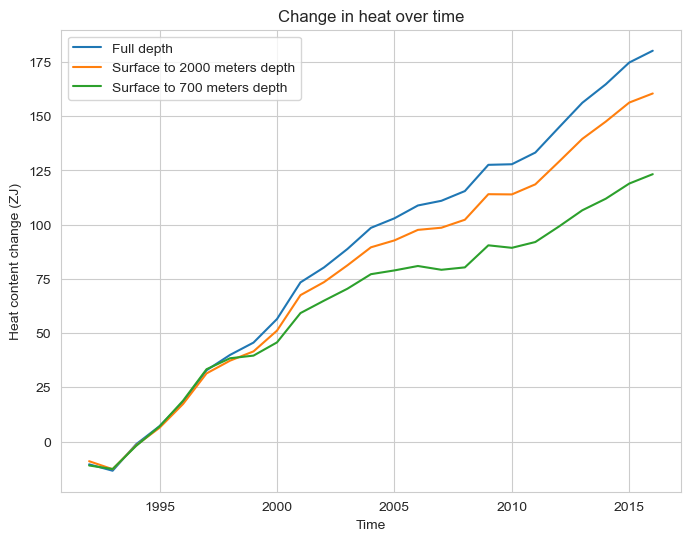

In [10]:
fig,ax = plt.subplots(figsize=(8,6))
sns.set_style(style="whitegrid") #comment out if don't want seaborn background
plt.plot(global_heat.year,heat_anom_fulldepth/10**21)
plt.plot(global_heat.year,heat_anom_upper2000/10**21)
plt.plot(global_heat.year,heat_anom_upper700/10**21)
plt.xlabel('Time')
plt.ylabel('Heat content change (ZJ)')
plt.legend(['Full depth','Surface to 2000 meters depth','Surface to 700 meters depth'])
plt.title('Change in heat over time')

We see that most heat gain is in the upper ocean - the change in the top 2000 meters is nearly equal to the full depth change. Based on this graph, what percentage of additional heat since 1992 is stored in the top 2000 meters?

# Section 3: Spatial locations of heat

Now we've seen how the ocean heat increase is concentrated near the ocean surface, let's look at where that heat is stored as a function of latitude and longitude. We can do this by creating a global map of ocean heat content in the upper 700 m of the ocean 

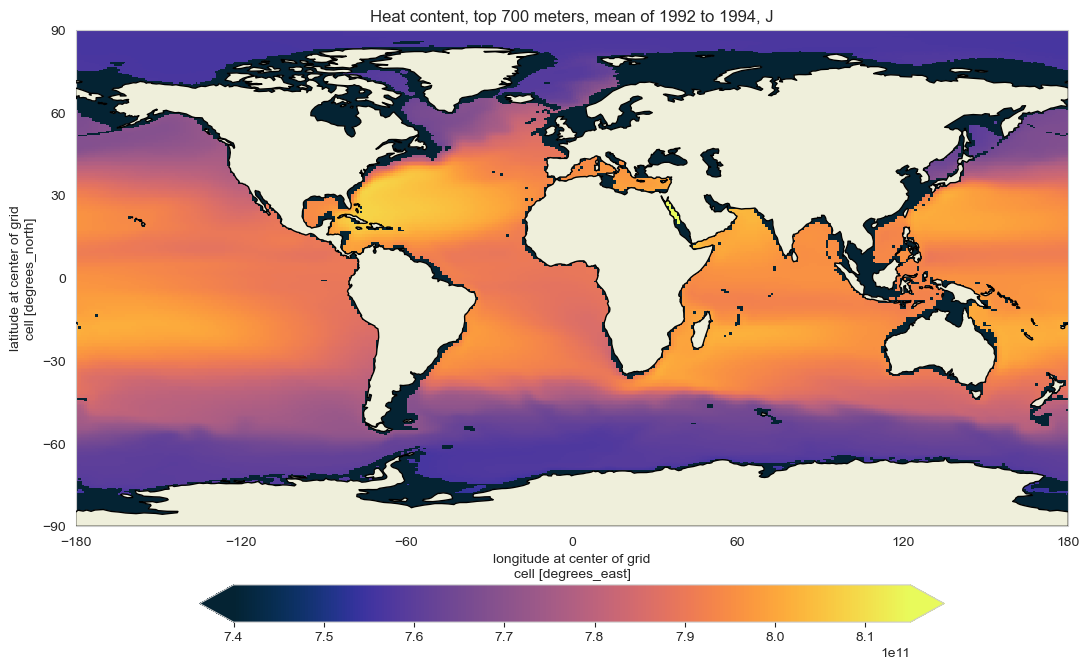

In [11]:
#First let's plot where heat is stored in the mean
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(((rho*c_p*subset_theta.where(-subset_theta.Zu<700)*subset_theta.dZ).sum('Z'))).plot(vmin=7.4E11,vmax=8.15E11,cmap=cmocean.cm.thermal,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': ""})
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Heat content, top 700 meters, mean of 1992 to 1994, J')
fig.tight_layout()

We can observe that the lower latitudes contain higher heat content compared to the higher latitudes. This finding is consistent with our previous plot of warmer waters near the Equator during this tutorial.

Now let's look at the spatial pattern of *heat gain* over 1992 to 2016

In [16]:
# We already defined an object that's the mean over years 1992 to 1994 (subset_theta)
# Now define an object that's the mean over 2014 to 2016
subset_theta_future=theta_annual.sel(year=slice('2014', '2016')).mean('year')

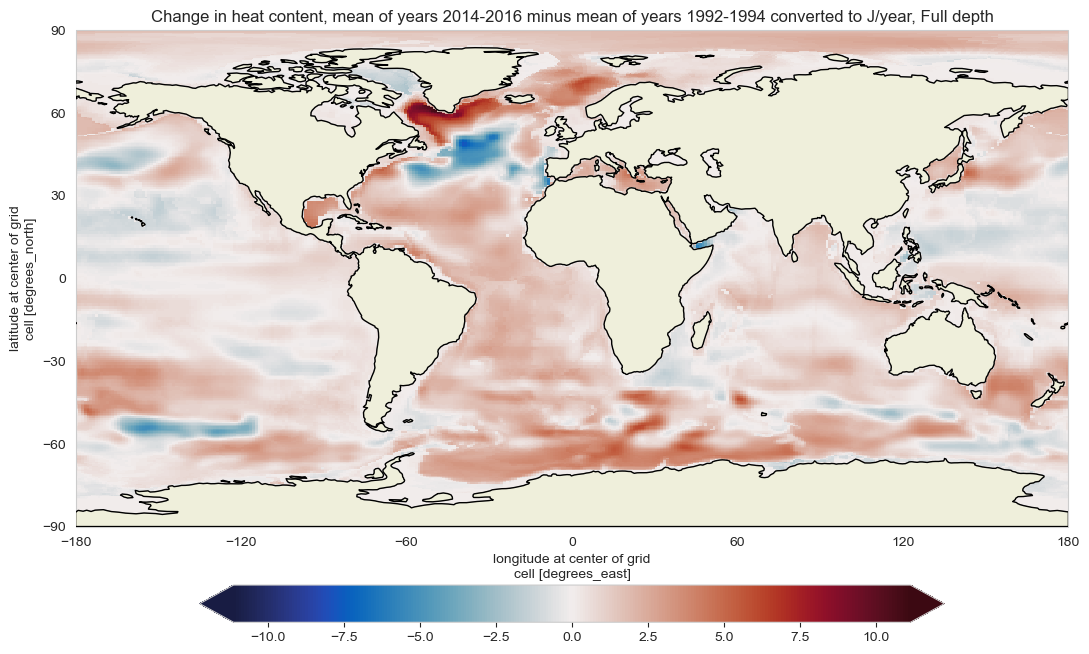

In [17]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.PlateCarree()},figsize=(11,12),dpi=100) #this is from cartopy https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html
p=(((rho*c_p*subset_theta_future*subset_theta_future.dZ).sum('Z')-(rho*c_p*subset_theta*subset_theta.dZ).sum('Z'))/(24*60*60*365*(2015-1993))).plot(cmap=cmocean.cm.balance,cbar_kwargs={'shrink':0.75,'orientation':'horizontal','extend':'both','pad':0.05,'label': ""})
ax.coastlines(color='grey',lw=0.5)
ax.set_xticks([-180, -120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='k')
plt.title('Change in heat content, mean of years 2014-2016 minus mean of years 1992-1994 converted to J/year, Full depth')
fig.tight_layout()

We can observe that heat gain is not evenly distributed across space. When comparing the two plots, we once again notice that the majority of heat gain occurs in the upper ocean.

# Summary

Throughout this tutorial, we've investigated the spatial patterns and temporal shifts of the ocean's heat content. We learned that the upper layers of the ocean, particularly within the top 2000 meters, contain most of the heat, with the majority of this heat gain occurring near the ocean surface. We developed a deeper understanding of heat content calculation, considering the essential elements such as specific heat capacity, reference density, and temperature. Furthermore, we noticed that heat content distribution varies by latitude and longitude, typically being higher in the lower latitudes nearer to the Equator. Lastly, we highlighted that the ocean's heat gain isn't uniformly distributed across different oceanic regions.